## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib notebook

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [19]:
import model

## Simulation mechanics

In [201]:
def c_bound(z: float, k: float, p:dict):
    """Upper bound on the amount that can be consumed
    
    .. math:: c_t \leq z_t\cdotk_t\cdot\alpha^{-\frac{1}{\mu}}
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    return z * k * p['alpha'] ** (-1 / p['mu'])


def bisection(z:float, g:float, k:float, p:dict, precision:float=1e-7):
    """ Determine the level of consumption using the bisection method
    
    .. math:: \frac{2\gamma}{1-\alpha} c_t -  G_t z_t \left(c_t^{-\mu } z_t^{\mu }\right)^{-\frac{\mu +1}{\mu }} \left(\frac{c_t^{-\mu } z_t^{\mu }-\alpha  k_t^{-\mu }}{1-\alpha }\right)^{\frac{2}{\mu }+1} = 0
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    g : float
        Consumption rate (% of income consumed)
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
    precision : float, default: 1e-5
        Precision of the bisection solution
    
    Returns
    -------
    c : float
        level of consumption
    """
    
    # Pre-compute constants
    mu = p['mu']
    lhs_1 = 2 * p['gamma'] / (1 - p['alpha'])
    rhs_1 = g * z / ((1 - p['alpha']) ** (2 / mu + 1))
    rhs_2 = p['alpha'] * k ** (-1 * mu)
    
    # Minimisation target for the bisection
    def diff(c: float):
        r = z / c
        rhs = rhs_1 * (r ** (-1 - mu)) * ((r ** mu) - rhs_2) ** (2 / mu + 1)
        return c * lhs_1 - rhs
    
    max_val = c_bound(z, k, p)
    
    # Adapt by precision to avoid asymptotic bounds
    edge = precision * 1e-2
    x = [edge, max_val / 2, max_val-edge]
    abs_lst = [abs(diff(i)) for i in x[:2]]
    
    if x[-1] < -1:
        fig, ax = plt.subplots(1,1)
        y = np.linspace(precision, 0.05, 100)
        ax.plot(y, diff(y))
        plt.show()
        
    while min(abs_lst) >= precision:
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]
        
        # If we are close to the bound:
        if max_val - x[0] <= precision:
            break

    return x[np.argmin(abs_lst)]

In [203]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    s = s_
    
    # Determine Consumption
    c = bisection(z, g, k_, p, err)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    test = [income>0, w>0, n>0, k_>0, q_>0, b_>0]
    assert all(test), print("w:{:.2f} n:{:.2f} b:{:.2f} q:{:.2f} k:{:.2f}".format(w,n,b_,q_,k_))
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Retain previous news formula out of interest
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    step_news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin
    news = np.tanh(p['n_theta'] * step_news)

    return z, c, n, b, w, k, q, g, s, news, income, xiz, xin

In [204]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3, err:float=1e-4):
    """ Complete a t_end period simulation of the whole system
    
    Parameters
    ----------
    start : np.ndarray
        starting variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
    t_end : float
        Duration of the simulation
        
    Returns
    -------
    df : pd.DataFrame
        timeseries of the simulation results
    """
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p, err)
        if any([x[t,1]<err, x[t,2]<err, x[t,5]<err]): # c, n, k
            break
    x = x[:t+10,:]
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100 * (1-df.loc[:,'g'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

<IPython.core.display.Javascript object>


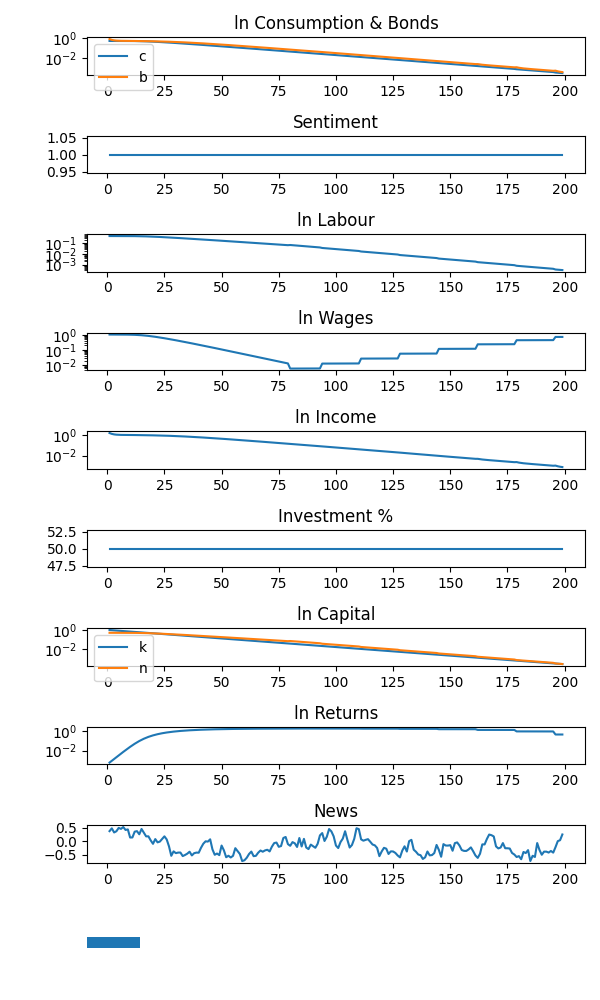

,z,c,n,b,w,k,q,g,s,news,income,xiz,xin,inv,bc
1,1.0,0.521707,0.499805,0.813260,1.043019,0.960000,0.000610,0.5,1.0,0.376932,1.610415,0.0,-0.025227,50.0,1.558845
2,1.0,0.521594,0.499716,0.670032,1.042612,0.921600,0.000927,0.5,1.0,0.481370,1.326797,0.0,0.185743,50.0,1.284587
3,1.0,0.521447,0.499603,0.598344,1.042017,0.884736,0.001409,0.5,1.0,0.327077,1.184840,0.0,-0.093400,50.0,1.147468
4,1.0,0.521208,0.499414,0.562379,1.041154,0.849347,0.002138,0.5,1.0,0.372801,1.113621,0.0,0.097762,50.0,1.078991
5,1.0,0.520854,0.499132,0.544218,1.039906,0.815373,0.003235,0.5,1.0,0.497477,1.077659,0.0,0.211107,50.0,1.044857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,0.000383,0.000398,0.000514,0.445576,0.000349,0.861271,0.5,1.0,-0.428383,0.001019,0.0,-0.088695,50.0,1.342757
196,1.0,0.000343,0.000341,0.000532,0.723038,0.000335,0.423022,0.5,1.0,-0.223902,0.001053,0.0,0.261696,50.0,1.549594
197,1.0,0.000329,0.000327,0.000456,0.723305,0.000322,0.422625,0.5,1.0,0.002137,0.000904,0.0,0.243737,50.0,1.384828
198,1.0,0.000316,0.000314,0.000411,0.723583,0.000309,0.422212,0.5,1.0,0.037684,0.000814,0.0,0.075869,50.0,1.298952


In [206]:
params = {'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
          'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 2, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 9.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.1, g=0.5, s=1.0, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 2e2
np.random.seed(40)
view = (1, int(T))


df = simulate(start, params, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','b']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.n, True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.loc[:,['k','n']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = model.simulation_graph(graphs, size = (6, 10))
#axs['ln Returns'].axhline(params['interest'], color='red', linewidth=0.5)
df

---
## Steady-state Analysis

In [252]:
from itertools import product
import seaborn as sns

# Parameters to vary
num = 25
T = 5e2
macro_vars = ['c', 'n', 'b', 'k', 'q', 'w']

# Parameter Variations
g_list = np.linspace(1e-3, 1-1e-2, num)
s_list = np.linspace(1e-3, 1, num)

# Given parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
          'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 2, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 9.32}

results = {v:np.empty((num,num)) for v in macro_vars}

def sim_vars(g, s):
    start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.1, g=g, s=s, income=1, news=1, xiz=0, xin=0)
    start = np.array([v for _,v in start.items()])
    df = simulate(start, params, T)
    return df.iloc[-1, :]

# Test 1
res = {k:pd.DataFrame(index=g, columns=s, dtype=float) for k in macro_vars}

for g, s in product(g,s):
    x = sim_vars(g,s)
    for k in res.keys():
        res[k].loc[g,s] = x.loc[k]

<IPython.core.display.Javascript object>


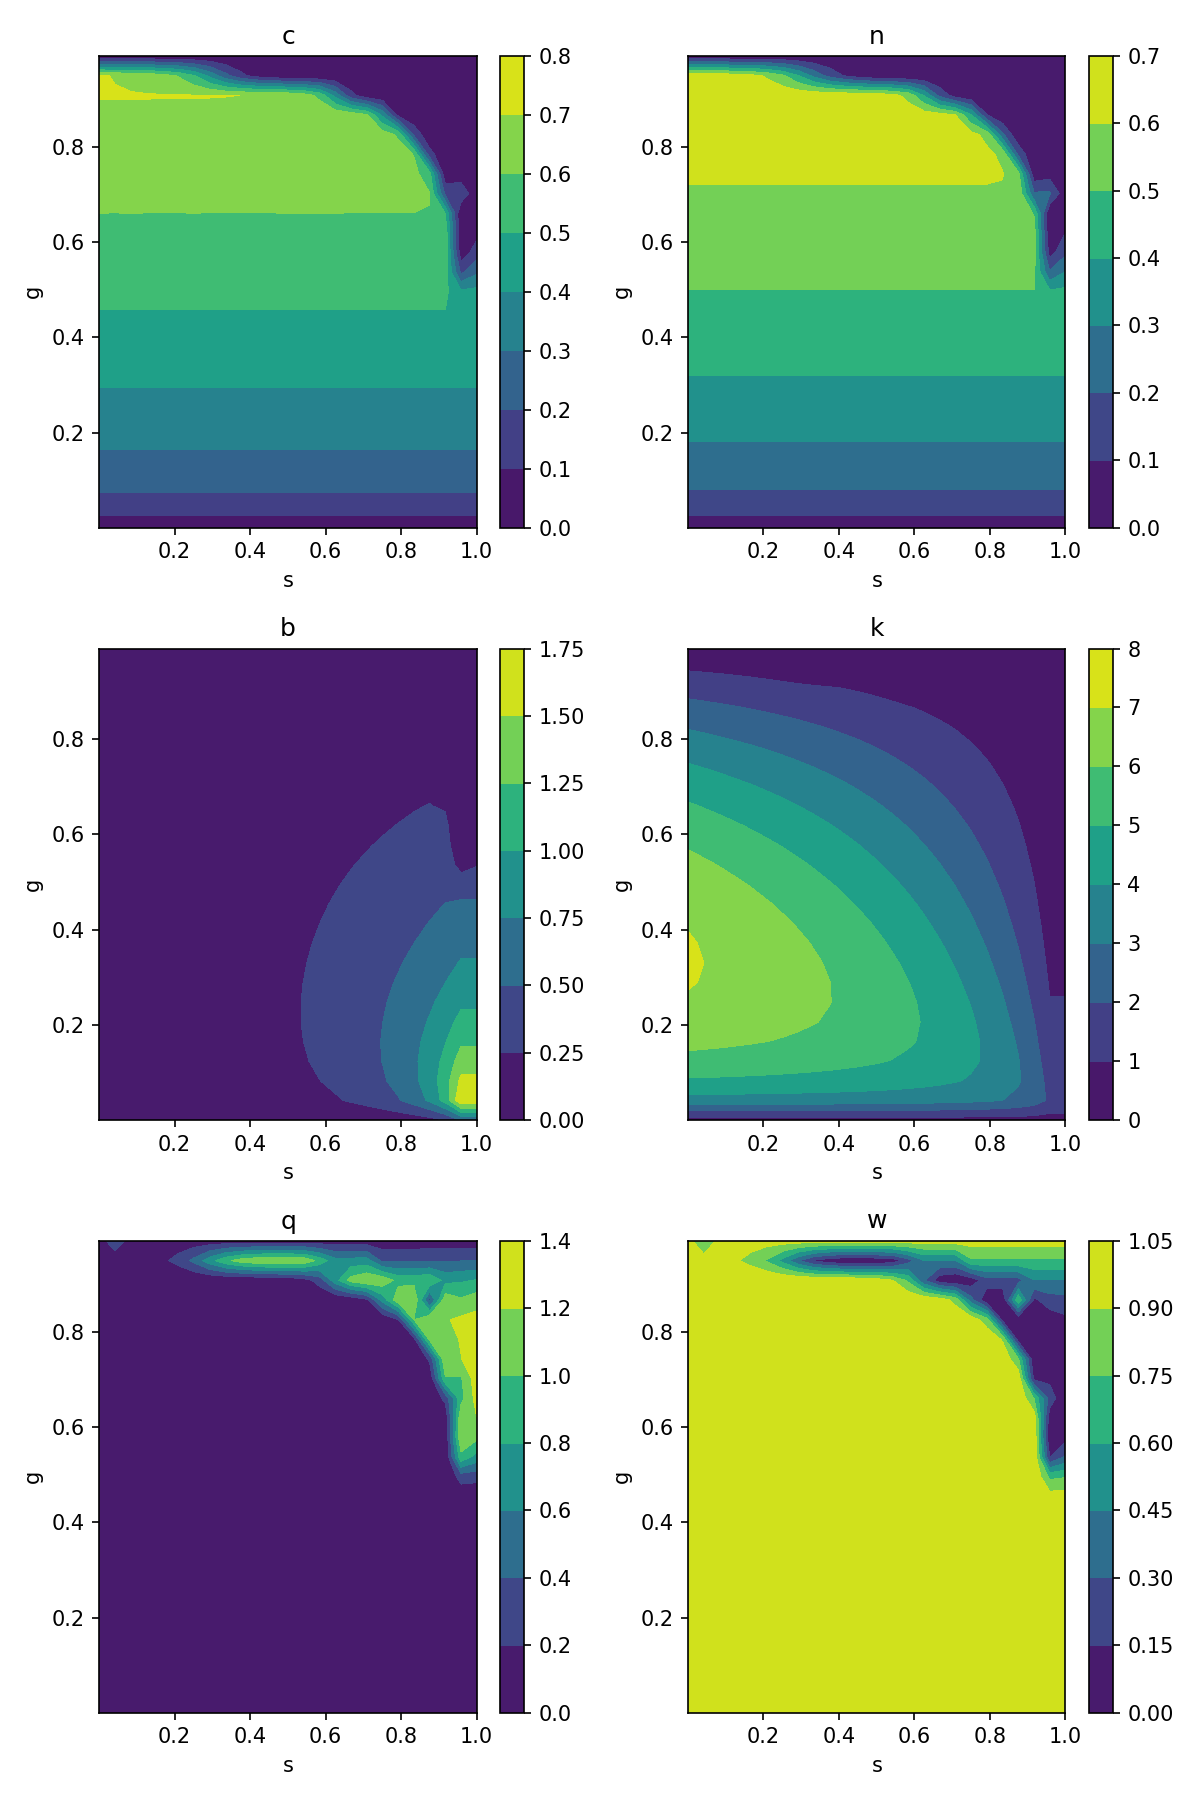

In [263]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
for i, k in enumerate(res.keys()):
    r, c = i//2, i%2
    ax[r, c].set_title(k)
    q = ax[r, c].contourf(s, g, res[k])
    ax[r, c].set_xlabel('s')
    ax[r, c].set_ylabel('g')
    cbar = plt.colorbar(q, ax=ax[r, c])
    
fig.tight_layout()
#plt.savefig('fig_steady_state_heatmap.pdf', bbox_inches='tight', format='pdf')